# Further Ideas: GAN that generates images similar to flower dataset

...

| Teammember |                    |
|------------|--------------------|
| 1.         | Nadine Weber       |
| 2.         | Patrick Singer     |


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
from datetime import datetime
import os
import time
from PIL import Image

%matplotlib inline

print(f"Tensorflow version: {tf.__version__} | Keras version: {keras.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-04-09 18:28:39.778905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Tensorflow version: 2.4.1 | Keras version: 2.4.0
Num GPUs Available:  1


2023-04-09 18:28:47.521149: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-09 18:28:47.523220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-09 18:28:47.575373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-04-09 18:28:47.575416: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-09 18:28:47.579003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-09 18:28:47.579067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-

Original dataset: max val = 255 | min val = 0
Normalized dataset: max val = 1.0 | min val = 0.0


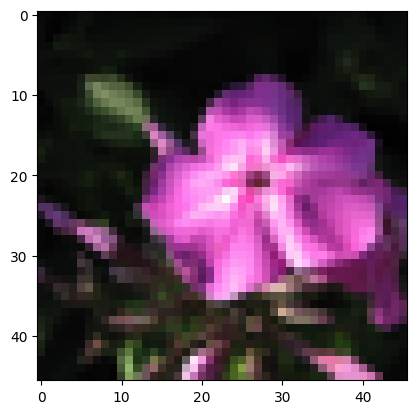

In [2]:
# Load Flower Dataset
img_dir = "./datasets/flowers"
train_x = np.empty((len(os.listdir(img_dir)), 46, 46, 3), dtype=np.uint8)

for i, img_file in enumerate(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_file)
    img = Image.open(img_path).convert("RGB").resize((46, 46))
    train_x[i] = np.array(img)

plt.imshow(train_x[0])
    
# Normalize dataset
train_x_norm = train_x/255
print(f"Original dataset: max val = {np.max(train_x)} | min val = {np.min(train_x)}")
print(f"Normalized dataset: max val = {np.max(train_x_norm)} | min val = {np.min(train_x_norm)}")

# Show one example image
plt.imshow(train_x[random.randint(0,len(train_x))]);

In [3]:
# Reshaping dataset (Conv2D wants input = (batch_size, height, width, channels))
x_train_reshaped = tf.convert_to_tensor(train_x_norm)
print(f"Dataset shape: {x_train_reshaped.shape}")

Dataset shape: (813, 46, 46, 3)


2023-04-09 18:28:52.109253: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 18:28:52.109703: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-09 18:28:52.110764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-04-09 18:28:52.110796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-09 18:28:52.110820: I tensorflow/stream_executor/platform/default/ds

In [4]:
def build_discriminator():
    model = keras.Sequential([
        keras.layers.Conv2D(input_shape=(46, 46, 3), filters=32, kernel_size=5, padding="same", activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Conv2D(filters=48, kernel_size=5, padding="same", activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1024, activation=keras.layers.LeakyReLU(alpha=0.01)),
        keras.layers.Dense(units=1, activation="sigmoid")
    ])
    
    return model

In [5]:
test_discriminator_model = build_discriminator()
test_discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
average_pooling2d (AveragePo (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 48)        38448     
_________________________________________________________________
average_pooling2d_1 (Average (None, 11, 11, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        76864     
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

**Testing model with sample image**

In [6]:
print(test_discriminator_model.predict(x_train_reshaped[0:1]))

2023-04-09 18:28:53.380362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-09 18:28:53.380796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3198120000 Hz
2023-04-09 18:28:53.500464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-09 18:28:53.655826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-04-09 18:28:54.225699: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-04-09 18:28:54.272803: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


[[0.49734655]]


In [7]:
from tensorflow.keras.layers import Layer

class CustomUpsample(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super().__init__(**kwargs)
        self.size = size
    
    def call(self, inputs):
        return tf.image.resize(inputs, size=self.size, method=tf.image.ResizeMethod.BILINEAR)

In [8]:
def build_generator(n, output_dim=46):
    l = ((output_dim*2)**2)*3
    
    model = keras.Sequential([
        keras.layers.Dense(input_shape=(n,), units=l, activation="relu"),
        keras.layers.Reshape((output_dim*2, output_dim*2, 3), input_shape=(l,)),
        keras.layers.Conv2D(filters=int(n/2), kernel_size=3, strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=int(n/4), kernel_size=3, strides=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=int(n/6), kernel_size=3, strides=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=int(n/8), kernel_size=3, strides=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=3, kernel_size=3, strides=(2, 2), activation="sigmoid")      
    ])
    
    return model

In [9]:
test_generator_model = build_generator(100, output_dim=46)
test_generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25392)             2564592   
_________________________________________________________________
reshape (Reshape)            (None, 92, 92, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 50)        1400      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 50)        200       
_________________________________________________________________
re_lu (ReLU)                 (None, 46, 46, 50)        0         
_________________________________________________________________
custom_upsample (CustomUpsam (None, 94, 94, 50)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 25)       

**Testing model with sample noise**

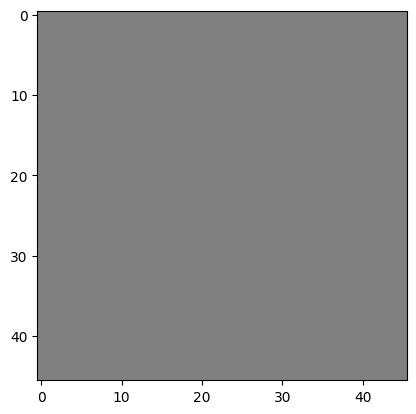

In [10]:
test_out = test_generator_model.predict(([random.random() for _ in range(100)],))
plt.imshow((test_out*255).astype('uint8').squeeze());

In [11]:
@tf.function
def binary_cross_entropy(y_true, y_pred, from_logits=True):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=from_logits)
    loss = bce(y_true, y_pred)
    return loss

@tf.function
def calc_discriminator_loss(real_output, fake_output):
    real_output_loss = binary_cross_entropy(tf.ones_like(real_output), real_output, from_logits=False)
    fake_output_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output, from_logits=False)
    
    total_loss = real_output_loss + fake_output_loss
    return tf.reduce_mean(total_loss)

@tf.function
def calc_generator_loss(fake_output):
    g_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)
    return g_loss

In [12]:
def create_log_folder():
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join("./tensorboard/flowers", current_time)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    file_writer = tf.summary.create_file_writer(log_dir)
    
    return file_writer, log_dir

In [13]:
# Show images of a batch
def show_imgs_of_batch(image_batch):
    fig = plt.figure()

    for i in range(len(image_batch)):
        fig.add_subplot(1, len(image_batch), i+1)
        plt.imshow(image_batch[i], cmap="gray")
        plt.axis('off')
    plt.show()

In [14]:
def pretrain_step(image_batch, generator_model, discriminator_model, discriminator_optimizer, noise_vector_length=100, show_details=False):
    image_batch = tf.convert_to_tensor(image_batch)   
    
    if show_details:
        show_imgs_of_batch(image_batch)
    
    # Generate fake images
    noise = tf.random.normal([len(image_batch), noise_vector_length])
    fake_img_batch = generator_model(noise, training=False)
    
    if show_details:
        show_imgs_of_batch(fake_img_batch)
    
    # Loss
    with tf.GradientTape(persistent=True) as tape:
        real_img_predictions = discriminator_model(image_batch, training=True)   
        fake_img_predictions = discriminator_model(fake_img_batch, training=True)
        
        if show_details:
            print(f"Real predictions:\n{real_img_predictions}\n"
                  f"Fake predictions:\n{fake_img_predictions}")
        
        loss = calc_discriminator_loss(real_img_predictions, fake_img_predictions)
        
        if show_details:
            print(f"Loss: {loss}")

    # Get gradients
    gradients = tape.gradient(loss, discriminator_model.trainable_variables)
    
    # Apply gradients to weights in model
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))

    return {"loss": loss.numpy(), 
            "real_img_confidence": tf.reduce_mean(real_img_predictions).numpy(),
            "fake_img_confidence": tf.reduce_mean(fake_img_predictions).numpy()}

In [15]:
def pretraining(batch_size, steps, generator_model, discriminator_model, discriminator_optimizer, train_data=x_train_reshaped):
    step_results = []
    fig = plt.figure(dpi=80)
    batches = [train_data[x:x+batch_size] for x in range(0, len(train_data),batch_size)]
    if len(batches) > steps:
        batches = batches[:steps]
    
    for batch_imgs in batches:
        step_result = pretrain_step(batch_imgs, generator_model, discriminator_model, discriminator_optimizer, show_details=False)
        step_results.append(step_result)
    
    # Plot
    fig.add_subplot(2, 1, 1)
    
    plt.plot([val["loss"] for val in step_results], "b")
    plt.title("Discriminator Pretraining")
    plt.ylabel("Loss")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    fig.add_subplot(2, 1, 2)
    plt.plot([val["real_img_confidence"] for val in step_results], "g", label="Real Images")
    plt.plot([val["fake_img_confidence"] for val in step_results], "r", label="Fake Images")
    plt.xlabel("Step")
    plt.ylabel("Confidence") 
    plt.legend()
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.show()

In [16]:
def train_step(image_batch, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, noise_vector_length=100, show_details=False):
    image_batch = tf.convert_to_tensor(image_batch)   
    
    # Loss
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        noise = tf.random.normal([len(image_batch), noise_vector_length])
        fake_img_batch = generator_model(noise, training=False)
        
        # Discriminator prediction for real and fakes
        real_img_predictions = discriminator_model(image_batch, training=True)   
        fake_img_predictions = discriminator_model(fake_img_batch, training=True)
        
        # Losses for both models
        dis_loss = calc_discriminator_loss(real_img_predictions, fake_img_predictions)
        gen_loss = calc_generator_loss(fake_img_predictions)
        
        if show_details:
            print(f"Discriminator Loss: {dis_loss}")
            print(f"Generator Loss: {gen_loss}")
            print(len(fake_img_batch))
            show_imgs_of_batch(fake_img_batch[0:5])
        
    # Get gradients
    dis_gradients = tape.gradient(dis_loss, discriminator_model.trainable_variables)
    gen_gradients = tape.gradient(gen_loss, generator_model.trainable_variables)

    # Apply gradients to weights in model
    discriminator_optimizer.apply_gradients(zip(dis_gradients, discriminator_model.trainable_weights))
    generator_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))
    
    return {"discriminator_loss": dis_loss.numpy(),
            "generator_loss": gen_loss.numpy(),
            "sample_images": fake_img_batch[:4]}

In [17]:
def training(batch_size, epochs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, train_data=x_train_reshaped, plot_every_x_epochs=10, file_writer=None):
    step_results_list = []
    total_trained_on_images = 0
    total_weight_adjustments = 0
    start_time = time.time()
    
    for epoch in range(1, epochs+1):
        
        # Shuffle new batches
        tf.random.shuffle(train_data)
        batches = [train_data[x:x+batch_size] for x in range(0, len(train_data),batch_size)]
        if len(batches[-1]) != batch_size:
            batches = batches[:-1]
        
        # Train one epoch 
        for batch_imgs in batches:
            step_results = train_step(batch_imgs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer)
            step_results_list.append({"discriminator_loss": step_results["discriminator_loss"], "generator_loss": step_results["generator_loss"]})
            
            total_trained_on_images += len(batch_imgs)
            total_weight_adjustments += 1
            
            # Write to file every 10 steps as described in the task
            if total_weight_adjustments % 10 == 0 and file_writer != None:
                with file_writer.as_default():
                    tf.summary.scalar("generator_loss", step_results['generator_loss'], step=total_weight_adjustments)
                    tf.summary.scalar("discriminator_loss", step_results['discriminator_loss'], step=total_weight_adjustments)
                    for i in range(1, len(step_results["sample_images"])):
                        tf.summary.image(f"sample_img_{i}", step_results["sample_images"][i-1:i], step=total_weight_adjustments)
            
            # Assign trained model instances to global variable (In case training needs to be resumed later) 
            global saved_generator_model, saved_discriminator_model, saved_discriminator_optimizer, saved_generator_optimizer
            saved_generator_model, saved_discriminator_model, saved_discriminator_optimizer, saved_generator_optimizer = generator_model, discriminator_model, discriminator_optimizer, generator_optimizer
            
        # Summary
        if epoch % plot_every_x_epochs == 0 or epoch == 1:
                        
            # Print summary
            print(f"Summary after epoch {epoch}\n" +"="*(20+len(str(epoch))))
            print(f"Training progress: {round((epoch/epochs)*100)}%")
            print(f"Time elapsed: {round(time.time() - start_time)} seconds")
            print(f"Current Discriminator Loss: {str(step_results['discriminator_loss'])[:5]}")
            print(f"Current Generator Loss: {str(step_results['generator_loss'])[:5]}")
            print(f"Total trained on images: {total_trained_on_images}")
            print(f"Total weight adjustments: {total_weight_adjustments}")
            
            # Plot summary
            fig = plt.figure(figsize=(8, 3), dpi=80)
            gs = fig.add_gridspec(2,5)
            
            ax1 = fig.add_subplot(gs[:, 0:3])
            ax1.plot([val["discriminator_loss"] for val in step_results_list], "r", label="Discriminator")
            ax1.plot([val["generator_loss"] for val in step_results_list], "g", label="Generator")
            ax1.set_title(f"Training after epoch {epoch}")
            ax1.set_xlabel("Step")
            ax1.set_ylabel("Loss")
            ax1.legend()
            
            ax2 = fig.add_subplot(gs[0, 3])
            ax2.imshow(step_results["sample_images"][0], cmap="gray")
            ax2.axis('off')
            ax3 = fig.add_subplot(gs[1, 3])          
            ax3.imshow(step_results["sample_images"][1], cmap="gray")
            ax3.axis('off')
            ax4 = fig.add_subplot(gs[0, 4])
            ax4.imshow(step_results["sample_images"][2], cmap="gray")
            ax4.axis('off')
            ax5 = fig.add_subplot(gs[1, 4])          
            ax5.imshow(step_results["sample_images"][3], cmap="gray")
            ax5.axis('off')

            plt.show()

In [18]:
def complete_training(generator_learn_rate, discriminator_learn_rate, batch_size, pretraining_steps, training_epochs, create_new_models=True, open_tensorboard=False):
    
    # Initialization
    if create_new_models:
        # New models
        generator_model = build_generator(100)
        discriminator_model = build_discriminator()
        # Optimizers
        generator_optimizer = tf.keras.optimizers.Adam(generator_learn_rate)
        discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_learn_rate)
        # Compile models
        discriminator_model.compile(loss=calc_discriminator_loss, optimizer=discriminator_optimizer)
        generator_model.compile(loss=calc_generator_loss, optimizer=generator_optimizer)
        print(">> Created new Models")
    else:
        # Load saved models
        try:
            generator_model = saved_generator_model
            discriminator_model = saved_discriminator_model
            discriminator_optimizer = saved_discriminator_optimizer
            generator_optimizer = saved_generator_optimizer
            print(">> Loaded saved Models")
        except NameError:
            print(">> No saved Models found")
            return
        
    # Create log folder
    file_writer, log_dir = create_log_folder()
    
    # Training
    if pretraining_steps > 0:
        print(">> Beginning Pretraining")
        pretrain_start_time = time.time()
        pretraining(batch_size, pretraining_steps, generator_model, discriminator_model, discriminator_optimizer, train_data=x_train_reshaped)
        print(f">> Finished Pretraining after {round(time.time() - pretrain_start_time)} seconds")
    else:
        print(">> Skipping Pretraining")
    
    print(">> Beginning Training\n")
    train_start_time = time.time()
    training(batch_size, training_epochs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, plot_every_x_epochs=100, file_writer=file_writer)
    print(f">> Finished Training after {round(time.time() - train_start_time)} seconds")
    
    if open_tensorboard:
        print(f">> Opening Tensorboard")
        !tensorboard --logdir={log_dir}
    
    return generator_model

Summary after epoch 17700
Training progress: 88%
Time elapsed: 14580 seconds
Current Discriminator Loss: 1.346
Current Generator Loss: 0.472
Total trained on images: 14160000
Total weight adjustments: 70800


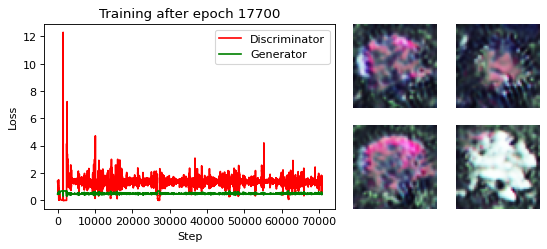

Summary after epoch 17800
Training progress: 89%
Time elapsed: 14662 seconds
Current Discriminator Loss: 1.277
Current Generator Loss: 0.490
Total trained on images: 14240000
Total weight adjustments: 71200


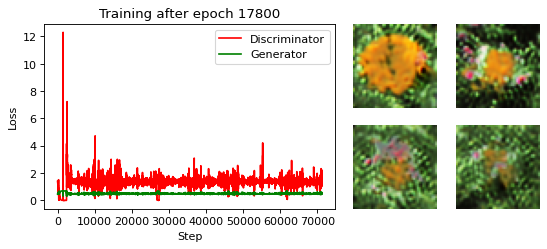

Summary after epoch 17900
Training progress: 90%
Time elapsed: 14745 seconds
Current Discriminator Loss: 1.364
Current Generator Loss: 0.478
Total trained on images: 14320000
Total weight adjustments: 71600


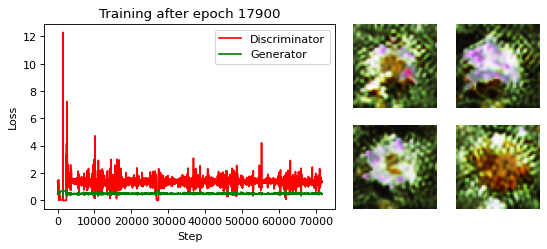

Summary after epoch 18000
Training progress: 90%
Time elapsed: 14827 seconds
Current Discriminator Loss: 1.746
Current Generator Loss: 0.460
Total trained on images: 14400000
Total weight adjustments: 72000


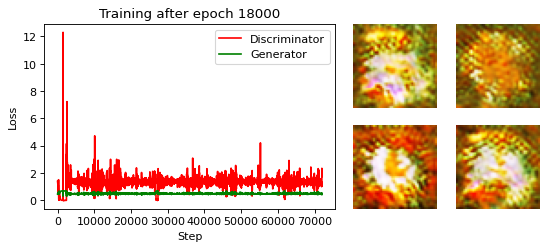

Summary after epoch 18100
Training progress: 90%
Time elapsed: 14910 seconds
Current Discriminator Loss: 1.361
Current Generator Loss: 0.558
Total trained on images: 14480000
Total weight adjustments: 72400


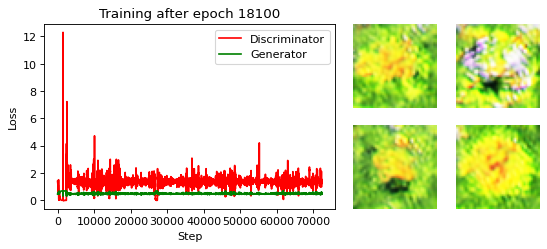

Summary after epoch 18200
Training progress: 91%
Time elapsed: 14992 seconds
Current Discriminator Loss: 1.101
Current Generator Loss: 0.563
Total trained on images: 14560000
Total weight adjustments: 72800


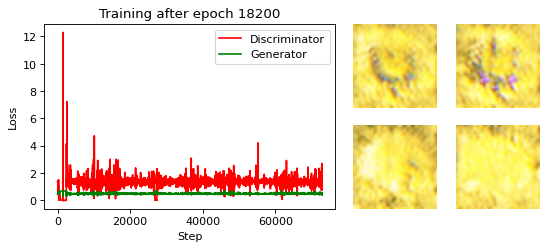

Summary after epoch 18300
Training progress: 92%
Time elapsed: 15075 seconds
Current Discriminator Loss: 1.456
Current Generator Loss: 0.478
Total trained on images: 14640000
Total weight adjustments: 73200


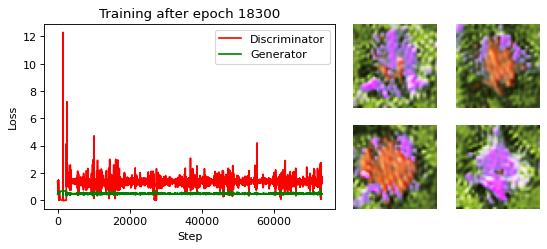

Summary after epoch 18400
Training progress: 92%
Time elapsed: 15157 seconds
Current Discriminator Loss: 1.996
Current Generator Loss: 0.511
Total trained on images: 14720000
Total weight adjustments: 73600


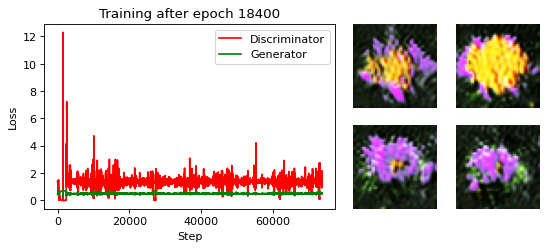

Summary after epoch 18500
Training progress: 92%
Time elapsed: 15240 seconds
Current Discriminator Loss: 1.399
Current Generator Loss: 0.463
Total trained on images: 14800000
Total weight adjustments: 74000


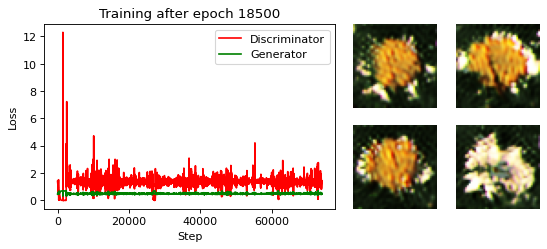

Summary after epoch 18600
Training progress: 93%
Time elapsed: 15323 seconds
Current Discriminator Loss: 1.510
Current Generator Loss: 0.475
Total trained on images: 14880000
Total weight adjustments: 74400


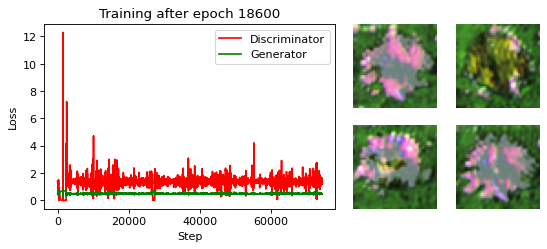

Summary after epoch 18700
Training progress: 94%
Time elapsed: 15406 seconds
Current Discriminator Loss: 1.650
Current Generator Loss: 0.455
Total trained on images: 14960000
Total weight adjustments: 74800


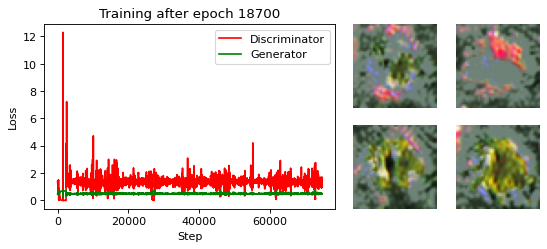

Summary after epoch 18800
Training progress: 94%
Time elapsed: 15488 seconds
Current Discriminator Loss: 1.336
Current Generator Loss: 0.487
Total trained on images: 15040000
Total weight adjustments: 75200


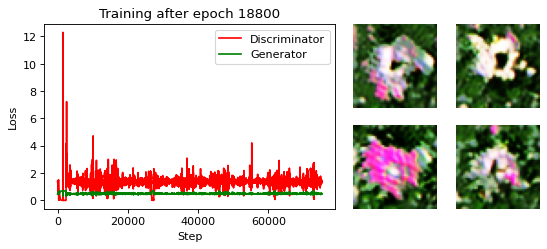

Summary after epoch 18900
Training progress: 94%
Time elapsed: 15570 seconds
Current Discriminator Loss: 1.429
Current Generator Loss: 0.469
Total trained on images: 15120000
Total weight adjustments: 75600


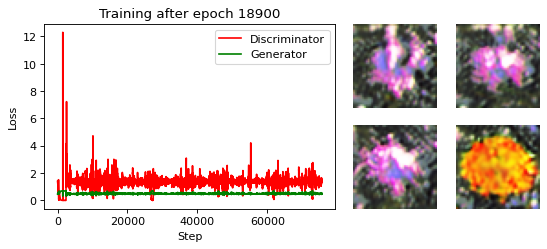

Summary after epoch 19000
Training progress: 95%
Time elapsed: 15653 seconds
Current Discriminator Loss: 0.674
Current Generator Loss: 0.600
Total trained on images: 15200000
Total weight adjustments: 76000


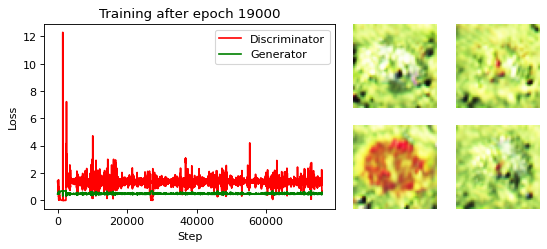

Summary after epoch 19100
Training progress: 96%
Time elapsed: 15735 seconds
Current Discriminator Loss: 1.385
Current Generator Loss: 0.467
Total trained on images: 15280000
Total weight adjustments: 76400


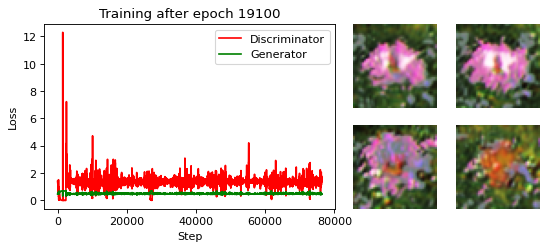

Summary after epoch 19200
Training progress: 96%
Time elapsed: 15818 seconds
Current Discriminator Loss: 1.236
Current Generator Loss: 0.502
Total trained on images: 15360000
Total weight adjustments: 76800


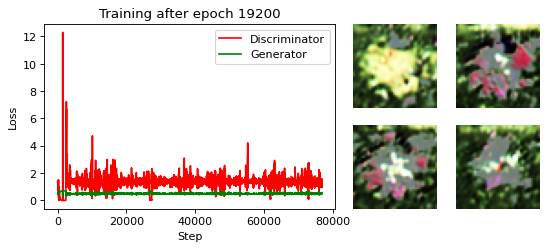

Summary after epoch 19300
Training progress: 96%
Time elapsed: 15901 seconds
Current Discriminator Loss: 1.575
Current Generator Loss: 0.492
Total trained on images: 15440000
Total weight adjustments: 77200


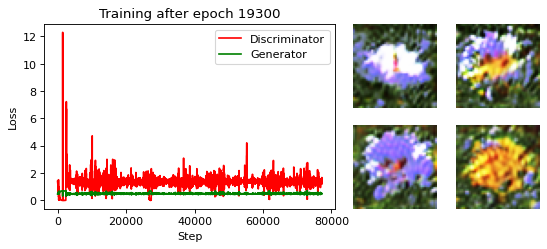

Summary after epoch 19400
Training progress: 97%
Time elapsed: 15983 seconds
Current Discriminator Loss: 1.317
Current Generator Loss: 0.490
Total trained on images: 15520000
Total weight adjustments: 77600


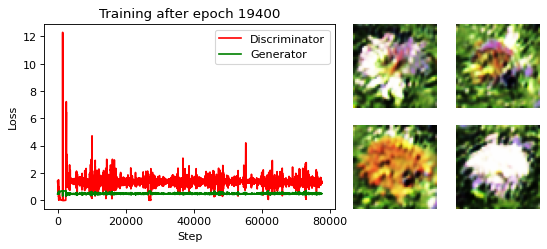

Summary after epoch 19500
Training progress: 98%
Time elapsed: 16066 seconds
Current Discriminator Loss: 1.485
Current Generator Loss: 0.473
Total trained on images: 15600000
Total weight adjustments: 78000


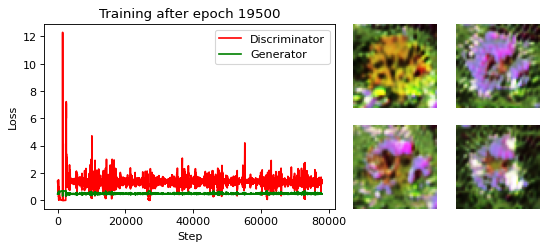

Summary after epoch 19600
Training progress: 98%
Time elapsed: 16148 seconds
Current Discriminator Loss: 1.382
Current Generator Loss: 0.500
Total trained on images: 15680000
Total weight adjustments: 78400


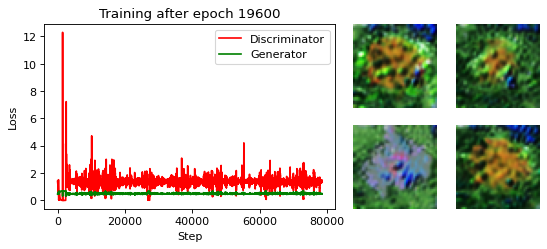

Summary after epoch 19700
Training progress: 98%
Time elapsed: 16231 seconds
Current Discriminator Loss: 1.372
Current Generator Loss: 0.465
Total trained on images: 15760000
Total weight adjustments: 78800


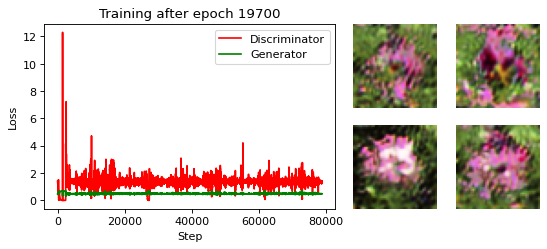

Summary after epoch 19800
Training progress: 99%
Time elapsed: 16314 seconds
Current Discriminator Loss: 1.402
Current Generator Loss: 0.514
Total trained on images: 15840000
Total weight adjustments: 79200


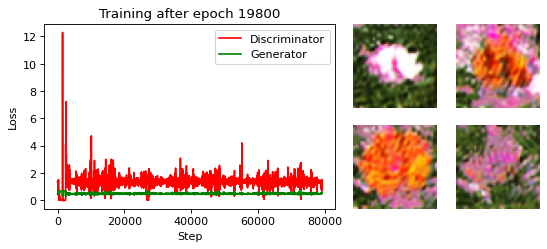

Summary after epoch 19900
Training progress: 100%
Time elapsed: 16397 seconds
Current Discriminator Loss: 1.370
Current Generator Loss: 0.486
Total trained on images: 15920000
Total weight adjustments: 79600


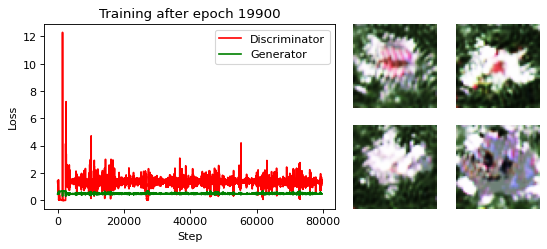

Summary after epoch 20000
Training progress: 100%
Time elapsed: 16480 seconds
Current Discriminator Loss: 1.246
Current Generator Loss: 0.493
Total trained on images: 16000000
Total weight adjustments: 80000


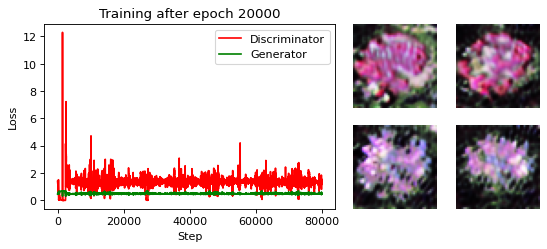

>> Finished Training after 16480 seconds


In [19]:
generator_model = complete_training(generator_learn_rate=0.0001, 
                                    discriminator_learn_rate=0.00001, 
                                    batch_size=200,
                                    pretraining_steps=0, 
                                    training_epochs=20000,
                                    create_new_models=True)

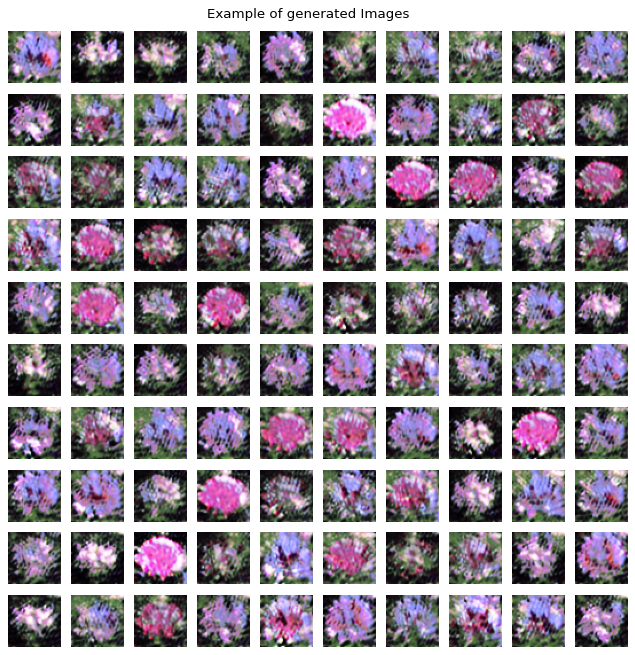

In [20]:
noise = tf.random.normal([100, 100])
fake_img_batch = generator_model(noise, training=False)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), dpi=80)
plt.suptitle("Example of generated Images", y=0.91)
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(fake_img_batch[i*10+j], cmap="gray")
        axes[i][j].axis('off')

plt.show()